In [1]:
import pandas as pd
import numpy as np
import re
%pylab inline
import sklearn as skl
import random
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.partial_dependence import plot_partial_dependence as PDP
from sklearn.externals import joblib 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn import preprocessing
from __future__ import print_function
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost as xgb
import copy
from sklearn.cross_validation import train_test_split
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("campaign_pd_basline.csv")

In [3]:
data_y = data['y']
data_x = data.drop('y', 1)

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=7)

In [47]:
class XGBoostClassifier():
        def __init__(self, num_boost_round=10, **params):
            self.clf = None
            self.num_boost_round = num_boost_round
            self.params = params
            self.params.update({'objective': 'multi:softprob'})

        def fit(self, X, y, num_boost_round=None):
            num_boost_round = num_boost_round or self.num_boost_round
            self.label2num = dict((label, i) for i, label in enumerate(sorted(set(y))))
            dtrain = xgb.DMatrix(X, label=[self.label2num[label] for label in y])
            self.clf = xgb.train(params=self.params
                                ,dtrain=dtrain
                                ,num_boost_round=num_boost_round
                                )

        def fit1(self, X1, y1, X2, y2, num_boost_round=None):
            num_boost_round = num_boost_round or self.num_boost_round
            self.label2num1 = dict((label, i) for i, label in enumerate(sorted(set(y1))))
            dtrain = xgb.DMatrix(X1, label=[self.label2num1[label] for label in y1])
            self.label2num2 = dict((label, i) for i, label in enumerate(sorted(set(y2))))
            dtest  = xgb.DMatrix(X2, label=[self.label2num2[label] for label in y2])
            watchlist=[(dtrain,'train'),(dtest,'test')]
            self.clf = xgb.train(params=self.params
                                ,dtrain=dtrain
                                ,num_boost_round=num_boost_round
                                ,evals=watchlist
                    ,early_stopping_rounds=20
                                )

        def get_best_ntree_limit(self,deep=True):
            return self.clf.best_ntree_limit

        def predict(self, X):
            num2label = dict((i, label)for label, i in self.label2num.items())
            Y = self.predict_proba(X)
            y = np.argmax(Y, axis=1)
            return np.array([num2label[i] for i in y])

        def predict_proba(self, X):
            dtest = xgb.DMatrix(X)
            return self.clf.predict(dtest)

        def score(self, X, y):
            Y = self.predict_proba(X)
            return 1 / logloss(y, Y)

        def get_params(self, deep=True):
            return self.params

        def set_params(self, **params):
            if 'num_boost_round' in params:
                self.num_boost_round = params.pop('num_boost_round')
            if 'objective' in params:
                del params['objective']
            self.params.update(params)
            return self

In [29]:
XGB_model = XGBoostClassifier(
                                eval_metric = 'auc',
                                num_class = 2,
                                #nthread = 4,
                                eta = 0.01,
                                num_boost_round = 1000,
                                max_depth = 3,
                                #subsample = 0.5,
                                colsample_bytree = 1.0,
                                silent = 1,
                                    )

XGB_model.fit(X_train, y_train)
pred_y_train = XGB_model.predict_proba(X_train)[:,1]
pred_y_test = XGB_model.predict_proba(X_test)[:,1]

In [30]:
def somersd(score, target, bins=500):
    pred = np.array([score, target]).T
    score, target = pred[pred.argsort(0)[:,0]].T
    #score, target = np.array(pd.DataFrame(pred).sort((0,1))).T
    
    n_1=float(sum(target))
    n_0=float(len(score)-n_1)
    
    pct_1=[0.0]
    pct_0=[0.0]

    for i in xrange(bins):
        end = int(float(i+1)/bins*len(pred))
        c_1 = sum(target[0:end])
        pct_1.append(c_1/n_1)
        pct_0.append((end-c_1)/n_0)

    pct_1.append(1.0)
    pct_0.append(1.0)
    
    sd=[(pct_1[i+1]+pct_1[i])*(pct_0[i+1]-pct_0[i]) for i in xrange(bins)]
    
    somersd=1-sum(sd)
    return somersd

def somers_plots(preds, bins=40):
    figsize(16,8)
    df = pd.DataFrame()
    for model, pred in preds.iteritems():
        mname = str(model)[:str(model).find("(")]
        #p = np.array(pd.DataFrame(pred).sort((0,1)))
        p = pred[pred.argsort(0)[:,0]]
        pct = []
        for i in xrange(bins):
            start = int(float(i)/bins*len(p))
            end = int(float(i+1)/bins*len(p))
            pct.append((i, np.mean(p[start:end,1])))
        pct = np.array(pct)
        for i in pct[:,1]:
            print (i)
        som = ' (%.3f)' % somersd(p[:,0], p[:,1])
        df = pd.concat([df, pd.DataFrame([pct, mname+som, som]).T])
         
    for k, v in df.sort(2, ascending=False).iterrows():
        pct = v.get_values()[0]
        plot(pct[:,0], pct[:,1], label=v[1])
    
    ylim(0,0.8)
    legend(loc='lower right')
    show()

0.0
0.0
0.000552791597568
0.00110619469027
0.000552791597568
0.0
0.0016592920354
0.0016583747927
0.00553097345133
0.0132669983416
0.0138274336283
0.0176991150442
0.037037037037
0.0691371681416
0.110005527916
0.160951327434
0.259955752212
0.398009950249
0.543694690265
0.728026533997
0.0
0.00221238938053
0.00442477876106
0.0
0.00663716814159
0.0
0.0
0.0110619469027
0.00442477876106
0.0221238938053
0.0110619469027
0.0265486725664
0.0464601769912
0.0485651214128
0.0907079646018
0.146017699115
0.212389380531
0.367256637168
0.530973451327
0.715231788079


/Users/kgx347/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


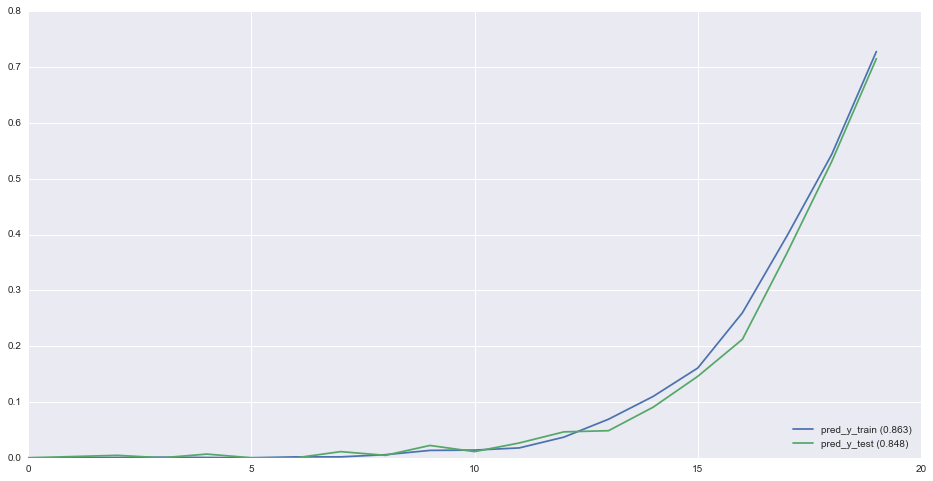

In [31]:
#plot lift chart
preds={} 
preds["pred_y_train "] = np.array(zip(pred_y_train, y_train))
preds["pred_y_test "] = np.array(zip(pred_y_test, y_test))
somers_plots(preds, bins=20)

## Partial Dependency plot

In [9]:
clf = GBC(n_estimators=100, max_depth=4, learning_rate=0.01, random_state=1)
clf.fit(X_train, y_train)

48

Convenience plot with ``partial_dependence_plots``
________________________________________________________________________________


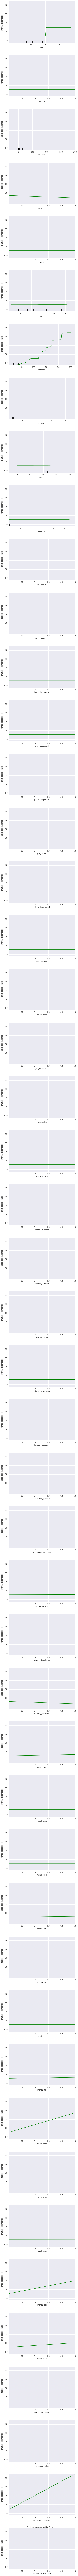

In [42]:
print('Convenience plot with ``partial_dependence_plots``')
names=data.columns.drop('y')

features = range(48)
fig, axs = PDP(clf, X_train, features, feature_names=names, n_cols=1, n_jobs=3, grid_resolution=100)
fig.suptitle('Partial dependence plot for Bank')
plt.subplots_adjust(top=50)  # tight_layout causes overlap with suptitle

print('_' * 80)

plt.show()

## Clean Data

In [49]:
data_clean = pd.read_csv("campaign_pd_cleaned.csv")

In [53]:
data_clean_y = data_clean['y']
data_clean_x = data_clean.drop('y', 1)

X_clean_train, X_clean_test, y_clean_train, y_clean_test = train_test_split(data_clean_x, data_clean_y, test_size=0.2, random_state=7)

In [54]:
XGB_model_clean = XGBoostClassifier(
                                eval_metric = 'auc',
                                num_class = 2,
                                #nthread = 4,
                                eta = 0.01,
                                num_boost_round = 1000,
                                max_depth = 3,
                                #subsample = 0.5,
                                colsample_bytree = 1.0,
                                silent = 1,
                                    )

XGB_model_clean.fit(X_clean_train, y_clean_train)
pred_y_clean_train = XGB_model_clean.predict_proba(X_clean_train)[:,1]
pred_y_clean_test = XGB_model_clean.predict_proba(X_clean_test)[:,1]

Exception AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x123328c50>> ignored


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fie    lds default, housing, loan

In [51]:
data_clean.describe()

,age,balance,day,duration,campaign,pdays,previous,y,month_ind,contact_ind,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,...,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985,0.044414,0.712017,...,0.601933,0.282896,0.151534,0.513194,0.294198,0.041074,0.108403,0.040698,0.033421,0.817478
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406,0.206015,0.452828,...,0.489505,0.450411,0.358572,0.499831,0.455687,0.198464,0.310892,0.197592,0.179735,0.386278
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
len(data_clean.columns)

25